# **Genotype_Phenotype_CNN Project**

## **Importing important Libraries**

In [1]:
%matplotlib inline
%load_ext tensorboard
#!pip install keras-tuner
import pandas as pd
import numpy as np
import tensorflow as tf
for gpu in tf.config.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(gpu, True)
from matplotlib import pyplot as plt
import keras_tuner as kt
from sklearn.metrics import confusion_matrix, accuracy_score

2023-04-27 15:36:59.544243: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-27 15:36:59.651470: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-27 15:37:00.207578: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/rkannan/miniconda3/envs/richard_tf/lib/
2023-04-27 15:37:00.207633: W tensorflow

## **Loading Datasets**

In [2]:
genotypeFile = 'genotype.csv'
genotype = pd.read_csv(genotypeFile, sep = '\t', index_col = 0)
print('genotypeFile shape:', genotype.shape )

phenotypeFile = 'phenotype.csv'
multi_pheno = pd.read_csv(phenotypeFile, sep = ',', index_col = 0)
print('Phenotype_Multi shape:', multi_pheno.shape )


# take a small part to test code
# genotype
X = genotype
# X = genotype.iloc[0:1000:, 0:5000]
# single_pheno
Y = multi_pheno.iloc[:, 3]#index=2 --> 1_E6-Berbamine_1
# Y = multi_pheno.iloc[0:1000, pheno_i]


# # Add noise
# random missing masker
missing_perc = 0.1
nonmissing_ones = np.random.binomial(
    1, 1 - missing_perc, size=X.shape[0] * X.shape[1])
nonmissing_ones = nonmissing_ones.reshape(X.shape[0], X.shape[1])
nonmissing_ones, nonmissing_ones.shape

corrupted_X = X * nonmissing_ones
# corrupted_X.head()

# # Prepare data
# ## One-hot encoding

from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
#X_onehot = to_categorical(X)
corrupted_X_onehot = to_categorical(corrupted_X)
# corrupted_X_onehot.shape

# normlization
scaled_Y = (Y - Y.min()) / (Y.max() - Y.min())


def detect_outliers(df):
    outlier_indices = []

    Q1 = np.percentile(df, 25)
    Q3 = np.percentile(df, 75)
    IQR = Q3 - Q1
    outlier_step = 1.5 * IQR

    outlier_indices = df[(df < Q1 - outlier_step) |
                         (df > Q3 + outlier_step)].index

    return outlier_indices


temp_Y = scaled_Y[~scaled_Y.isna()]
outliers_index = detect_outliers(temp_Y)


# set outliers as NAN
scaled_Y_ = scaled_Y.copy()
scaled_Y_[outliers_index] = np.nan


# ## Split train and test
train_X, test_X, corrupted_train_X, corrupted_test_X, train_Y, test_Y = train_test_split(
    X, corrupted_X_onehot, scaled_Y_.iloc[:], test_size=0.1)

# split df to train and valid
train_X, valid_X, corrupted_train_X, corrupted_valid_X, train_Y, valid_Y = train_test_split(
    train_X, corrupted_train_X, train_Y, test_size=0.1)



x_train = to_categorical(pd.concat([train_X,train_Y],axis=1).dropna().iloc[:,0:-1])
y_train = train_Y.dropna().to_numpy()

x_valid = to_categorical(pd.concat([valid_X,valid_Y],axis=1).dropna().iloc[:,0:-1])
y_valid = valid_Y.dropna().to_numpy()

x_test = to_categorical(pd.concat([test_X,test_Y],axis=1).dropna().iloc[:,0:-1])
y_test  = test_Y.dropna().to_numpy()

genotypeFile shape: (4390, 28220)
Phenotype_Multi shape: (4390, 20)


## **PART 2 - BUILDING THE Model**

### Initializing the CNN and Building the layers

In [3]:
def model_build(pheno_name,num_hl,hl_list,hl_activation, out_activation, dropout_val,filters_, kernel_size_,stride_poolSize,Conv_Layers_Stride_Size):
    

    '''
    https://towardsdatascience.com/multi-output-model-with-tensorflow-keras-functional-api-875dd89aa7c6

    def DNN_build(num_hl,hl_list,hl_activation, out_activation, dropout_val):
    pheno_name = name of phenotype of interest
    num_hl = number of hidden layers
    hl_list = list of hidden layers
    hl_activation = hidden layer activation function
    out_activation = output layer activation function
    dropout_val = Dropout value
    '''
    assert(num_hl == len(hl_list))
    assert(num_hl == len(dropout_val))
    input_layer = tf.keras.Input(shape=(28220, 3))#(3138, 28220, 3)
    
    shared_convL1 = tf.keras.layers.Conv1D(filters = filters_,kernel_size = kernel_size_,strides = Conv_Layers_Stride_Size, activation = hl_activation,input_shape = (28220, 3))(input_layer)
    shared_convL1_max_pool = tf.keras.layers.MaxPool1D(pool_size=stride_poolSize, strides=stride_poolSize)(shared_convL1)
    
    shared_convL2 = tf.keras.layers.Conv1D(filters = filters_,kernel_size = kernel_size_,strides = Conv_Layers_Stride_Size, activation = hl_activation)(shared_convL1_max_pool)
    shared_convL2_max_pool = tf.keras.layers.MaxPool1D(pool_size=stride_poolSize, strides=stride_poolSize)(shared_convL2)
    
    shared_convLayer_Flatten = tf.keras.layers.Flatten()(shared_convL2_max_pool)
    initializer = tf.keras.initializers.HeNormal()
    kernel_regularizer_ = tf.keras.regularizers.L1L2(l1=0.0001, l2=0.0001)
    
    shared_hidden_layer1 = tf.keras.layers.Dense(kernel_regularizer=kernel_regularizer_,kernel_initializer=initializer,units = hl_list[0], activation  = hl_activation)(shared_convLayer_Flatten)
    shared_hidden_layer1_dp1 = tf.keras.layers.Dropout(dropout_val[0])(shared_hidden_layer1)

    #model 1
    model1_hidden_layer2 = tf.keras.layers.Dense(kernel_regularizer=kernel_regularizer_,kernel_initializer=initializer,units = hl_list[1], activation  = hl_activation)(shared_hidden_layer1_dp1)
    model1_hidden_layer2_dp2 = tf.keras.layers.Dropout(dropout_val[1])(model1_hidden_layer2)

    model1_hidden_layer3 = tf.keras.layers.Dense(kernel_regularizer=kernel_regularizer_,kernel_initializer=initializer,units = hl_list[2], activation  = hl_activation)(model1_hidden_layer2_dp2)
    model1_hidden_layer3_dp3 = tf.keras.layers.Dropout(dropout_val[2])(model1_hidden_layer3)

    model1_hidden_layer4 = tf.keras.layers.Dense(kernel_regularizer=kernel_regularizer_,kernel_initializer=initializer,units = hl_list[3], activation  = hl_activation)(model1_hidden_layer3_dp3)
    model1_hidden_layer4_dp4 = tf.keras.layers.Dropout(dropout_val[3])(model1_hidden_layer4)
    model1_hidden_layer4_dp4_fl = tf.keras.layers.Flatten()(model1_hidden_layer4_dp4)
    
    pheno_name_ = tf.keras.layers.Dense(units = 1, name = pheno_name, activation  = out_activation)(model1_hidden_layer4_dp4_fl)#1_CobaltChloride_1
    model = tf.keras.models.Model(inputs = input_layer, outputs = [pheno_name_])

    return model

## **PART 3 - TRAINING THE MODEL**

### **Compiling the CNN and Training the CNN on the Training set**

In [20]:
#ann.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy','mse'])#change metrics to MSE
def compile_model(pheno_name,model,loss_, learningRate, metrics_): #loss = 'sparse_categorical_crossentropy'
    '''
    def compile_model(DNN, loss_, learningRate, metrics_):
    DNN: the model
    loss_: the loss function
    learningRate: learning rate
    metrics_: metrics of interest ['accuracy', 'mse']
    '''

    # Specify the optimizer, and compile the model with loss functions for both outputs
    model.compile(
       #optimizer = tf.keras.optimizers.Adam(learning_rate=learningRate),#0.00027705 
    optimizer =  tf.keras.optimizers.SGD(learning_rate=learningRate, momentum=0.8, nesterov=True, name="SGD"),
      loss = {
          pheno_name:loss_
      }, 
      metrics = [metrics_]#{'CobaltChloride_1':[metrics_],'CopperSulfate_1':[metrics_],'Diamide_1':[metrics_]}
      )#change metrics to MSE ##['accuracy','mse']
    return model

def runModel(model, val_split_size, batch_size_,numEpochs, patience_, monitor_, mode,pheno_index):
    '''
    def buildModel(DNN, val_split_size, batch_size_,numEpochs, patience_, monitor_, mode):
    DNN: DNN which the model
    val_split_size: the validation split)
    batch_size_: batch_size
    numEpochs: number of epochs
    patience_: patience of call back
    monitor_: monitor (objective of callback)
    mode: mode (min, max, auto)
    pheno_index: the index of the phenotype in y_train
    '''
    history = model.fit(
    x_train, 
    [y_train[:]],
    validation_data=(x_valid, [y_valid[:]]),
    batch_size = batch_size_, 
    epochs = numEpochs,
    callbacks = [
      tf.keras.callbacks.EarlyStopping(monitor= monitor_,patience=patience_,verbose=1,mode=mode),#monitoring loss mode should be min [---val_acc--]
      #tf.keras.callbacks.ModelCheckpoint(filepath='./TrainedModels/model.{epoch:02d}-{val_loss:.2f}.h5',save_best_only=True),
      #tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    ]
    )

    return history



## Model Evaluation

In [21]:
def evaluateModel_loss(history,model_name,label_loss,val_label_loss):
    print()
    plt.plot(history.history[label_loss])
    plt.plot(history.history[val_label_loss])
    plt.title(model_name + ' Training and Validation loss')
    plt.ylabel('Mean Squared Error')
    plt.xlabel('epochs')
    plt.legend(['Training loss','Validation loss'], loc = 'upper left')
    #plt.savefig("Training_validation_loss_with_i.jpg")
    plt.show()
    plt.close()
    #plt.show()
    print()
def evaluateModel_metric(history,model_name,label_acc,val_label_acc):
    print()
    plt.plot(history.history[label_acc])
    plt.plot(history.history[val_label_acc])
    plt.title(model_name+' Training and Validation Mean Qquared Error')
    plt.ylabel('Mean Squared Error')
    plt.xlabel('epochs')
    plt.legend(['Training Accuracy','Validation Accuracy'], loc = 'upper left')
    #plt.show()
    #plt.savefig("Training_validation_accuracy_with_i.jpg")
    plt.show()
    plt.close()
    print()

## **Putting it All Together**

In [55]:
def runModel_all(pheno_name, pheno_index,hl_list, drop_list):
    model_mse = model_build(pheno_name,4,hl_list,'relu','linear',drop_list,8,7,2,3)#model initiallization
    model_mse = compile_model(pheno_name,model_mse,tf.keras.losses.MeanSquaredError(reduction="auto", name="mse"),
    0.00123695244,'mse')
    history_mse =  runModel(model_mse,0.30,32,400,15, "val_mse", "min",pheno_index)
    return history_mse,model_mse

### Run for '1_E6-Berbamine_1' at index 1 in y_train

In [56]:
history_mse,model_mse = runModel_all('1_E6-Berbamine_1',3,[1464,608,264,146],[0.50,0.50,0.00,0.50])

/home/rkannan/miniconda3/envs/richard_tf/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/400
108/108 [==============================] - 3s 14ms/step - loss: 17.7396 - mse: 0.0849 - val_loss: 17.6503 - val_mse: 0.0326
Epoch 2/400
108/108 [==============================] - 1s 12ms/step - loss: 17.6161 - mse: 0.0344 - val_loss: 17.5732 - val_mse: 0.0285
Epoch 3/400
108/108 [==============================] - 1s 12ms/step - loss: 17.5403 - mse: 0.0315 - val_loss: 17.5004 - val_mse: 0.0285
Epoch 4/400
108/108 [==============================] - 1s 13ms/step - loss: 17.4663 - mse: 0.0302 - val_loss: 17.4274 - val_mse: 0.0281
Epoch 5/400
108/108 [==============================] - 1s 12ms/step - loss: 17.3923 - mse: 0.0287 - val_loss: 17.3547 - val_mse: 0.0279
Epoch 6/400
108/108 [==============================] - 1s 12ms/step - loss: 17.3191 - mse: 0.0278 - val_loss: 17.2823 - val_mse: 0.0276
Epoch 7/400
108/108 [==============================] - 1s 12ms/step - loss: 17.2467 - mse: 0.0275 - val_loss: 17.2104 - val_mse: 0.0277
Epoch 8/400
108/108 [===========================

Epoch 61/400
108/108 [==============================] - 1s 12ms/step - loss: 13.6433 - mse: 0.0260 - val_loss: 13.6132 - val_mse: 0.0270
Epoch 62/400
108/108 [==============================] - 1s 12ms/step - loss: 13.5821 - mse: 0.0262 - val_loss: 13.5519 - val_mse: 0.0270
Epoch 63/400
108/108 [==============================] - 1s 12ms/step - loss: 13.5208 - mse: 0.0261 - val_loss: 13.4908 - val_mse: 0.0270
Epoch 64/400
108/108 [==============================] - 1s 12ms/step - loss: 13.4598 - mse: 0.0260 - val_loss: 13.4299 - val_mse: 0.0269
Epoch 65/400
108/108 [==============================] - 1s 12ms/step - loss: 13.3990 - mse: 0.0260 - val_loss: 13.3692 - val_mse: 0.0269
Epoch 66/400
108/108 [==============================] - 1s 12ms/step - loss: 13.3384 - mse: 0.0260 - val_loss: 13.3087 - val_mse: 0.0269
Epoch 67/400
108/108 [==============================] - 1s 12ms/step - loss: 13.2780 - mse: 0.0260 - val_loss: 13.2484 - val_mse: 0.0270
Epoch 68/400
108/108 [===================

108/108 [==============================] - 1s 12ms/step - loss: 7.6338 - mse: 0.0252 - val_loss: 7.6148 - val_mse: 0.0265
Epoch 181/400
108/108 [==============================] - 1s 12ms/step - loss: 7.5941 - mse: 0.0255 - val_loss: 7.5749 - val_mse: 0.0265
Epoch 182/400
108/108 [==============================] - 1s 12ms/step - loss: 7.5542 - mse: 0.0254 - val_loss: 7.5351 - val_mse: 0.0265
Epoch 183/400
108/108 [==============================] - 1s 12ms/step - loss: 7.5145 - mse: 0.0254 - val_loss: 7.4955 - val_mse: 0.0265
Epoch 184/400
108/108 [==============================] - 1s 12ms/step - loss: 7.4749 - mse: 0.0253 - val_loss: 7.4560 - val_mse: 0.0264
Epoch 185/400
108/108 [==============================] - 1s 12ms/step - loss: 7.4356 - mse: 0.0254 - val_loss: 7.4168 - val_mse: 0.0264
Epoch 186/400
108/108 [==============================] - 1s 12ms/step - loss: 7.3963 - mse: 0.0252 - val_loss: 7.3776 - val_mse: 0.0264
Epoch 187/400
108/108 [==============================] - 1s 12

108/108 [==============================] - 1s 12ms/step - loss: 3.8951 - mse: 0.0146 - val_loss: 3.8838 - val_mse: 0.0149
Epoch 301/400
108/108 [==============================] - 1s 12ms/step - loss: 3.8722 - mse: 0.0146 - val_loss: 3.8604 - val_mse: 0.0144
Epoch 302/400
108/108 [==============================] - 1s 12ms/step - loss: 3.8491 - mse: 0.0143 - val_loss: 3.8379 - val_mse: 0.0146
Epoch 303/400
108/108 [==============================] - 1s 12ms/step - loss: 3.8264 - mse: 0.0142 - val_loss: 3.8155 - val_mse: 0.0148
Epoch 304/400
108/108 [==============================] - 1s 13ms/step - loss: 3.8037 - mse: 0.0141 - val_loss: 3.7930 - val_mse: 0.0147
Epoch 305/400
108/108 [==============================] - 1s 12ms/step - loss: 3.7816 - mse: 0.0144 - val_loss: 3.7711 - val_mse: 0.0152
Epoch 306/400
108/108 [==============================] - 1s 12ms/step - loss: 3.7592 - mse: 0.0142 - val_loss: 3.7479 - val_mse: 0.0142
Epoch 307/400
108/108 [==============================] - 1s 12

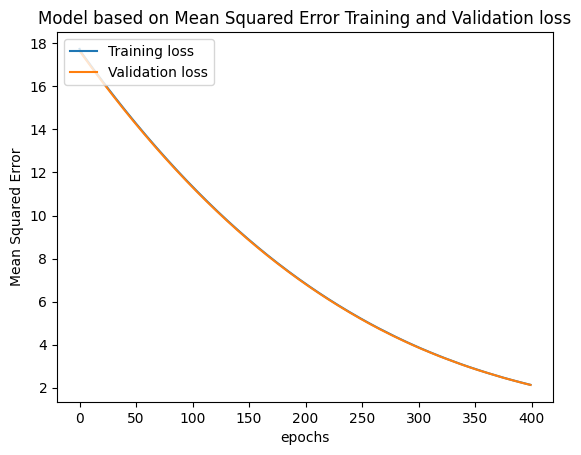

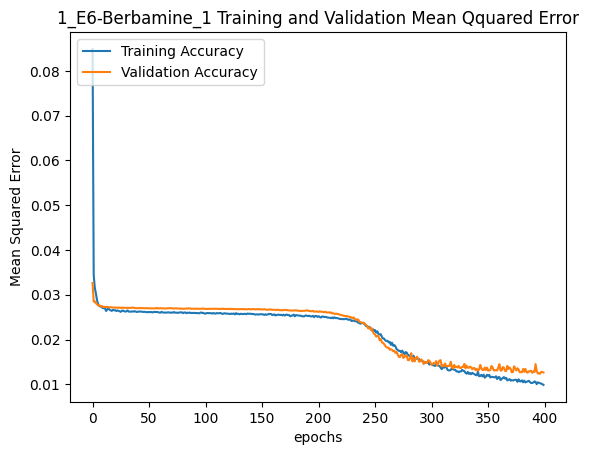

In [57]:
pheno_name='1_E6-Berbamine_1'
evaluateModel_loss(history_mse,'Model based on Mean Squared Error','loss','val_loss')
evaluateModel_metric(history_mse,pheno_name,'mse','val_mse')

In [58]:
model_mse.save('saved Models/1_E6-Berbamine_1.h5')

In [59]:
print(history_mse.history['val_mse'][-1])

0.012645328417420387


In [60]:
print(history_mse.history['mse'][-1])

0.00987202487885952


14/14 [==============================] - 0s 5ms/step
(1, 425)
count    425.000000
mean       0.360529
std        0.122727
min        0.228106
25%        0.261192
50%        0.312023
75%        0.432172
max        0.762829
Name: 1_E6-Berbamine_1, dtype: float64

count    425.000000
mean       0.372697
std        0.164470
min        0.028367
25%        0.258042
50%        0.302027
75%        0.473918
max        0.801250
Name: 1_E6-Berbamine_1_actual, dtype: float64


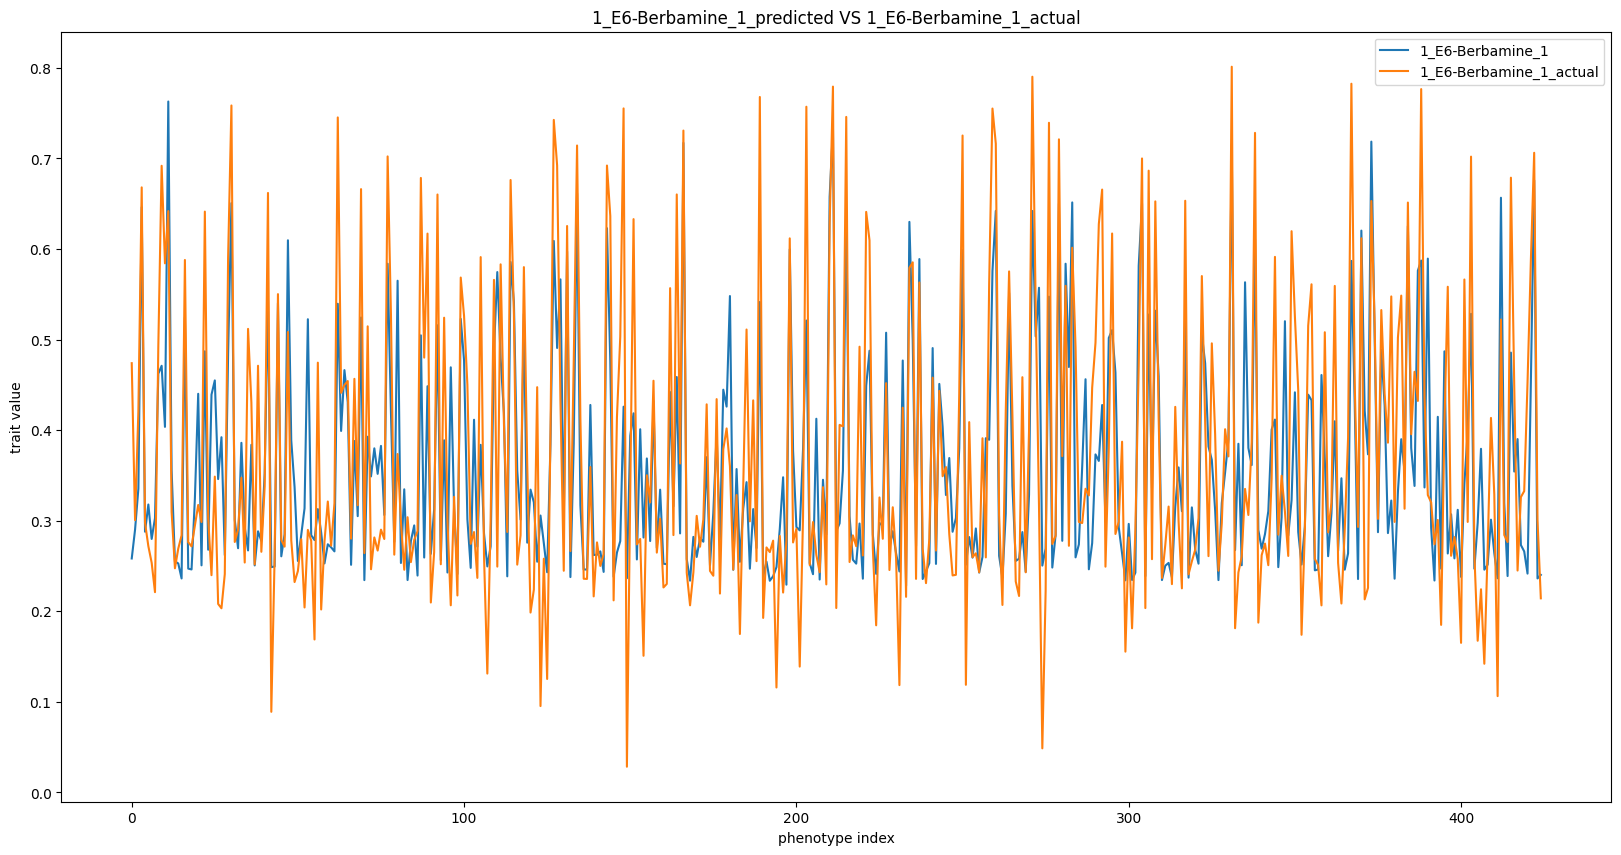

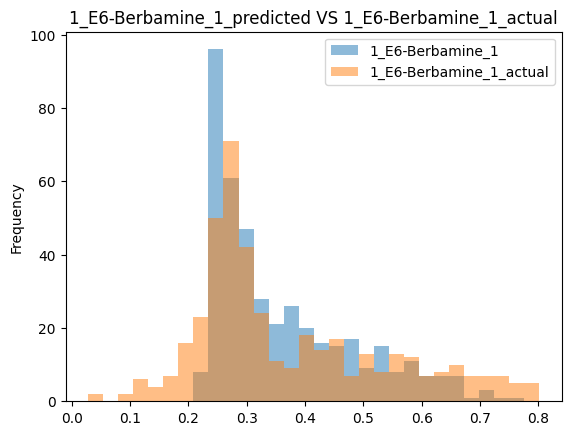

In [61]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tqdm.auto import tqdm
import itertools

phenoName = '1_E6-Berbamine_1'
phenoIdx = 3
def modelEvals_test_data(phenoName, phenoIdx,model):
    predicted_labels = np.array(model.predict(np.stack(x_test.reshape((425, 28220,3))))).T
    print(predicted_labels.shape)
    #print(predicted_labels[0,:])
    df = pd.DataFrame(predicted_labels[0,:],columns=[phenoName])
    df[str(phenoName+'_actual')] = y_test[:]
    print(df[phenoName].describe())
    print()
    print(df[str(phenoName+'_actual')].describe())
    
    pred1=df[[phenoName,str(phenoName+'_actual')]]
    pred1.plot.line(figsize=(20,10),title= str(phenoName+'_predicted' +' VS '+str(phenoName+'_actual')),xlabel='phenotype index',ylabel='trait value')
    pred1.plot.hist(bins=30, alpha=0.5, title= str(phenoName+'_predicted' +' VS '+str(phenoName+'_actual')),xlabel='phenotype Value',ylabel='Frequency')
modelEvals_test_data(phenoName, phenoIdx,model_mse)

In [3]:
#load saved model
model_mse = tf.keras.models.load_model('saved Models/1_E6-Berbamine_1.h5')
evaluate_data = model_mse.evaluate(
    x_test, y_test, verbose=1, batch_size=32)
#print(evaluate_data)

# predict
predict_data = model_mse.predict(x_test)

2023-04-27 15:37:34.696046: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-27 15:37:36.346347: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7961 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:19:00.0, compute capability: 7.5
2023-04-27 15:37:36.346958: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14167 MB memory:  -> device: 1, name: Quadro RTX 5000, pci bus id: 0000:1a:00.0, compute capability: 7.5
2023-04-27 15:37:36.347415: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task

14/14 [==============================] - 0s 5ms/step
